<a href="https://colab.research.google.com/github/Ardalan-gerami81/HW_ML/blob/main/Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Denoising using Autoencoder and PCA
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = 99102112
            <br />
            Name = Ardalan   
            <br />
            Last_Name = Gerami
        </div>
    </font>
    </div>


1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Visualize original images, their corresponding noisy images and their reconstructed versions side by side.
4. Repeat the previous steps using PCA algorithm.

# Import Necessary Libraries

In [96]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from skimage.util import random_noise
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST

# Load Dataset and Prepare It

In [97]:
# first we should download our dataset and seperate train and test set
ransform = transforms.Compose([
        transforms.ToTensor()
    ])
BATCH_SIZE = 64
trainset = MNIST(
            root='.',
            train=True,
            download=True,
            transform=transform
        )
testset = MNIST(
            root='.',
            train=False,
            download=True,
            transform=transform
        )
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [114]:
# now as project wants from us we should define a function which add guassian ->
#-> noise to input images
def get_noisy_images(test_or_trainloader, sigma = 0.1):
    gaussian_n_t_imgs = []
    for img in test_or_trainloader:
      image, _ = img[0], img[1]
      batch,h,row,col = image.shape
      gaussian_noisy_img = image + np.random.normal(0,sigma,(batch,h,row,col)).reshape(batch,h,row,col)
      # normalizing the noisy image
      for i in range(batch):
        gaussian_noisy_img[i, :, :, :] *= (1.0/np.max(gaussian_noisy_img[i, :, :, :].numpy()))
      gaussian_n_t_imgs.append(gaussian_noisy_img)
    return gaussian_n_t_imgs

# Define Your Model
torch neural network model

In [115]:
# first we should our device on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# now let's define our class for model
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder Layers
        self.layer1 = nn.Linear(np.prod(trainset[0][0].shape).item(), 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)
        self.layer5 = nn.Linear(16, 10)
        # Decoder Layers
        self.layer6 = nn.Linear(10, 16)
        self.layer7 = nn.Linear(16, 32)
        self.layer8 = nn.Linear(32, 64)
        self.layer9 = nn.Linear(64, 128)
        self.layer10 = nn.Linear(128, np.prod(trainset[0][0].shape).item())
    # define  N = bATCH_SIZE
    def forward(self, x):
        # start with:                    # N * 784
        x = F.relu(self.layer1(x))       # N * 128
        x = F.relu(self.layer2(x))       # N * 64
        x = F.relu(self.layer3(x))       # N * 32
        x = F.relu(self.layer4(x))       # N * 16
        x = self.layer5(x)               # N * 10
        x = F.relu(self.layer6(x))       # N * 16
        x = F.relu(self.layer7(x))       # N * 32
        x = F.relu(self.layer8(x))       # N * 64
        x = F.relu(self.layer9(x))       # N * 128
        x = F.sigmoid(self.layer10(x))   # N * 784
        return x
model = AutoEncoder().to(device)

# Fit The Model
Also Define optimizer, Criterion and other parameters

In [117]:
# now first we define our Loss and optimizer for this model
# Loss :
Loss = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), 0.01)
# run the get_noisy_images function
noisy_images = get_noisy_images(trainloader,sigma = 0.1)
for epoch in range(15):
    # first we set the running loss as zero
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Train the model and also print the running loss for each batch
        org_image, _ = data
        noisy_image = noisy_images[i]
        c_org_image = org_image.clone().detach().requires_grad_(True).to(device).reshape(-1, 28*28)
        c_noisy_img_copy = noisy_image.clone().detach().requires_grad_(True).to(device).reshape(-1, 28*28).to(torch.float32)
        loss = Loss(model.forward(c_noisy_img_copy), c_noisy_img_copy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        if (i+1)%100 == 0:
            print(f'Epoch [{epoch+1}/{15}], Batch [{i+1}/{len(trainloader)}], Loss: {loss.item():.5f}')

Epoch [1/15], Batch [100/938], Loss: 0.04753
Epoch [1/15], Batch [200/938], Loss: 0.04644
Epoch [1/15], Batch [300/938], Loss: 0.04051
Epoch [1/15], Batch [400/938], Loss: 0.04117
Epoch [1/15], Batch [500/938], Loss: 0.03940
Epoch [1/15], Batch [600/938], Loss: 0.03638
Epoch [1/15], Batch [700/938], Loss: 0.03885
Epoch [1/15], Batch [800/938], Loss: 0.03669
Epoch [1/15], Batch [900/938], Loss: 0.03391
Epoch [2/15], Batch [100/938], Loss: 0.03490
Epoch [2/15], Batch [200/938], Loss: 0.03723
Epoch [2/15], Batch [300/938], Loss: 0.03049
Epoch [2/15], Batch [400/938], Loss: 0.03416
Epoch [2/15], Batch [500/938], Loss: 0.03443
Epoch [2/15], Batch [600/938], Loss: 0.03219
Epoch [2/15], Batch [700/938], Loss: 0.03452
Epoch [2/15], Batch [800/938], Loss: 0.03342
Epoch [2/15], Batch [900/938], Loss: 0.03125
Epoch [3/15], Batch [100/938], Loss: 0.03277
Epoch [3/15], Batch [200/938], Loss: 0.03671
Epoch [3/15], Batch [300/938], Loss: 0.02887
Epoch [3/15], Batch [400/938], Loss: 0.03209
Epoch [3/1

# Plot The Results

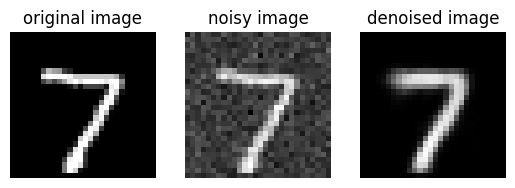

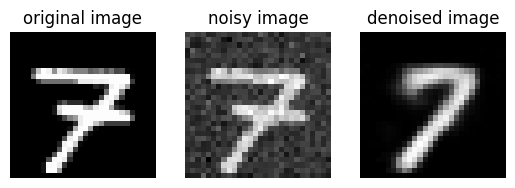

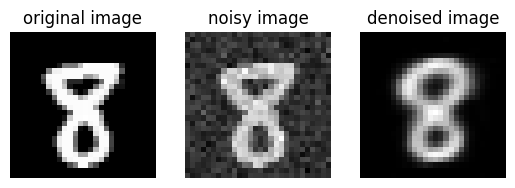

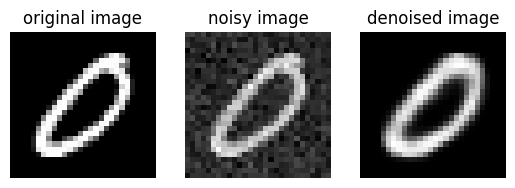

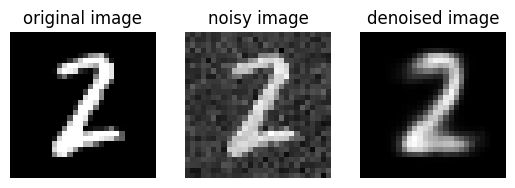

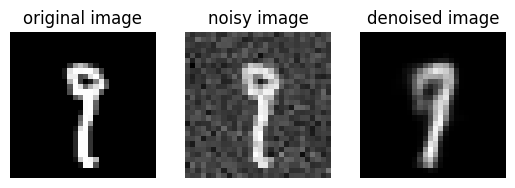

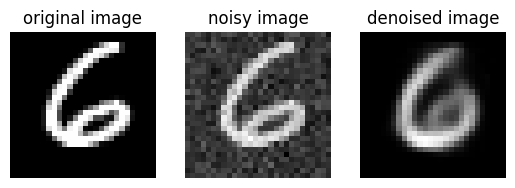

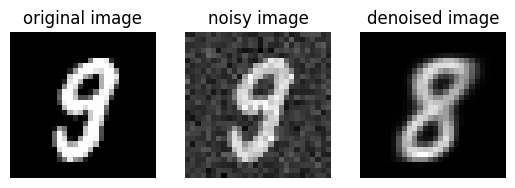

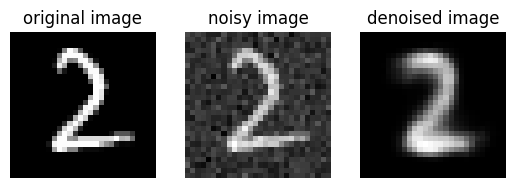

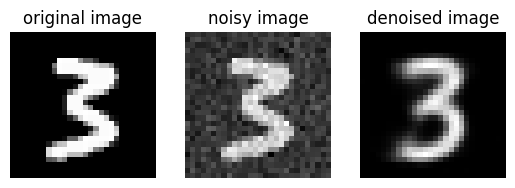

In [133]:
noisy_test_images = get_noisy_images(testloader,sigma = 0.1)
for i, data in enumerate(testloader, 0):
    if i>=10:
        break
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(data[0][0][0], cmap='gray')
    plt.title('original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_test_images[i][0][0], cmap='gray')
    plt.title('noisy image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    with torch.no_grad():
        rec = model.forward(noisy_test_images[i][0][0].to(device).reshape(-1, 28*28).to(torch.float32))
        plt.imshow(rec.cpu().reshape(28, 28), cmap='gray')
    plt.title('denoised image')
    plt.axis('off')

# PCA

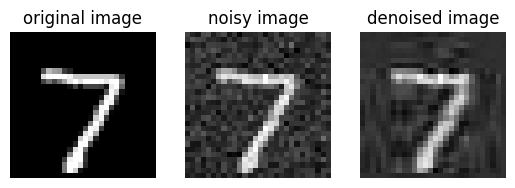

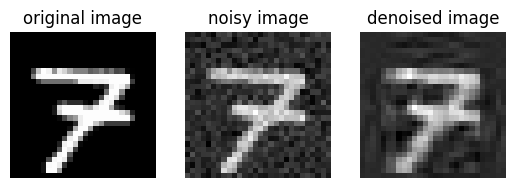

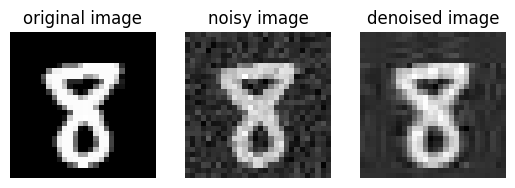

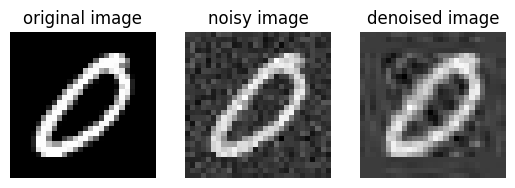

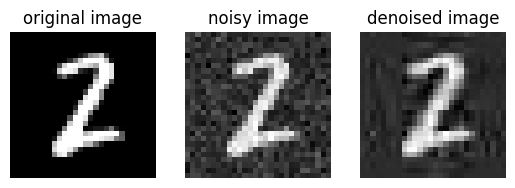

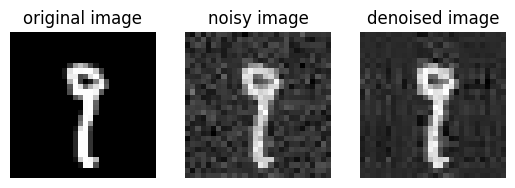

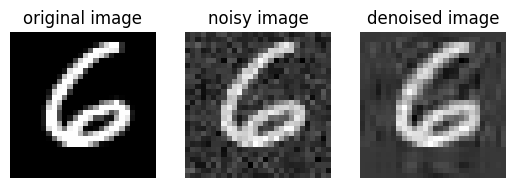

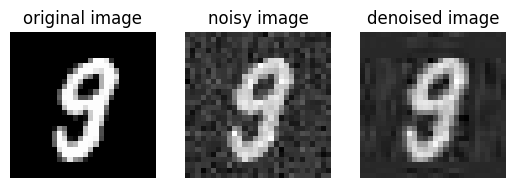

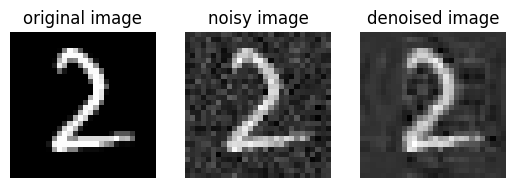

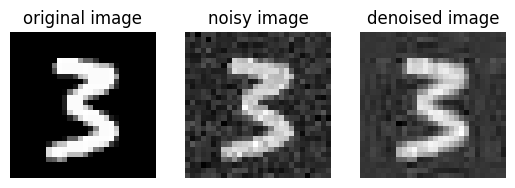

In [134]:
for i, data in enumerate(testloader, 0):
    if i>=10:
        break
    img,_ = data
    img = img[0][0].numpy()
    row,col = img.shape
    gaussian_noisy_img = img + np.random.normal(0,0.1,(row,col))
    gaussian_noisy_img*= (1.0/np.max(gaussian_noisy_img))
    U, Sigma, V_T = np.linalg.svd(gaussian_noisy_img)
    r_img = U[:, 0:5]@np.diag(Sigma[0:5])@V_T[0:5, :]
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(gaussian_noisy_img, cmap='gray')
    plt.title('noisy image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(r_img, cmap='gray')
    plt.title('denoised image')
    plt.axis('off')